# CNN + GlobalAvgPool
Derived from notebook LSTM 132. 

Combined cell lines. Coding RNA up to 4K. 

This was dying on CoLab, running out of RAM during keras.model.fit().
We tried releasing every bit of memory but nothing helped.
It was clearly a memory leak, as footprint increased on every call to fit(),
even if the model had been set to None and regenerated.

Here, we just barely squeeked by, running just under the RAM limit on CoLab.
We used RAN len 1K to 4K (instead of 200 to 4K)
and we delayed constructing the X_valid sets until training was over.

The results were impressive:  
Cross validation 5 folds 3 epochs  
 accuracy mean 74.57% +/- 0.68  
 precision mean 75.58% +/- 0.90  
 recall mean 96.95% +/- 0.52   
 F1 mean 84.94% +/- 0.52   

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2023-01-18 22:36:18.951588
Python 3.8.10
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
RCI_THRESHOLD=0.0
CFILTERS=64
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=3
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = False   # break after first fold
MINLEN=1000
MAXLEN=4000   

In [3]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/


In [4]:
GENES_FILE =    'CNRCI_coding_train_genes.csv'
RCI_FILE =      'CNRCI_coding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_coding_train_transcripts.gc42.csv'
COUNTS_FILE=    'CNRCI_coding_train_counts.K4.gc42.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549',\
      'H1.hESC',\
      'HeLa.S3',\
      'HepG2',\
      'HT1080',\
      'HUVEC',\
      'MCF.7',\
      'NCI.H460',\
      'NHEK',\
      'SK.MEL.5',\
      'SK.N.DZ',\
      'SK.N.SH',\
      'GM12878',\
      'K562',\
      'IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()
EXCLUSIONS = [1,7]
for c in EXCLUSIONS:
    print('Exclude cell line',c,all_cell_lines[c])

Exclude cell line 1 H1.hESC
Exclude cell line 7 NCI.H460


## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,exclusions=[]):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        overall_sum = 0
        overall_count = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    rci_max = None
                    rci_count = 0
                    cell_line = 0 # first line is 0 = A549
                    for rci_str in fields:
                        if rci_str != "nan" and cell_line not in exclusions:
                            rci_val = float(rci_str)
                            if rci_max is None or rci_val > rci_max:
                                rci_max = rci_val
                            rci_count += 1
                        cell_line += 1   
                    if rci_count > 0:
                        gene_to_rci[gene_id] = rci_max
                        overall_sum += rci_max
                        overall_count += 1
        overall_mean = overall_sum / overall_count
        print('Number of RCI values',overall_count)
        print('Mean RCI value',overall_mean)
        return gene_to_rci
    
    def seq_to_kmer_values(self,rna,K):
        # The cache may represent more than one K. Probably not a problem.
        N_indicator = 0 # indicator value
        vec=[] # seq converted to list of K-mers 
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def rci_to_label(self,rci):
        CYTO_LABEL = 1
        NUCLEAR_LABEL = 0
        # cnrci = log (cyto-to-nuclear ratio)
        # rci > 0 implies cytoplasmic
        if rci > RCI_THRESHOLD:
            return CYTO_LABEL
        return NUCLEAR_LABEL

    def load_sequence(self,filepath):
        labels=[]
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        rci_val = gene_to_rci[gene_id]
                        rci_label = self.rci_to_label(rci_val)
                        labels.append(rci_label)
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        return labels,allids,allseq
    
loader = DataLoader()
# test it
print(loader.seq_to_kmer_values('AAAA',3))
print(loader.seq_to_kmer_values('CATT',3))
print(loader.seq_to_kmer_values('TTGA',3))
print(loader.seq_to_kmer_values('TTTN',3))
# test it
print(loader.rci_to_label(-0.9))
print(loader.rci_to_label(1.1))

[1, 1]
[20, 16]
[63, 57]
[64, 0]
0
1


In [7]:
print(datetime.now())
print("Load RCI values...")
loader = DataLoader()
filepath = DATA_DIR+RCI_FILE
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
print('Example RCI:', list(gene_to_rci.items())[:3])
print("Load genes...")
all_genes = list(gene_to_rci.keys())
print(datetime.now())
print('Load sequence...')
filepath = DATA_DIR+SEQUENCE_FILE
labels,allids,allseq = loader.load_sequence(filepath)
print(datetime.now())
print('Num IDs:',len(allids))
print('Example IDs:',[allids[x] for x in [10, 20, 30, 40]] )
print('Count',np.count_nonzero(labels),'ones out of',len(labels),'labels.')
print('Num labels:',len(labels))
print('Example labels:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num sequences:',len(allseq))
print('Example sequence:',allseq[3])
loader = None  # drop K-mer cache to save RAM

2023-01-18 22:36:30.814477
Load RCI values...
Number of RCI values 13512
Mean RCI value 0.742330935725574
Num RCI: 13512
Example RCI: [('ENSG00000000003', 2.29436), ('ENSG00000000419', 2.1946), ('ENSG00000000457', 0.434284)]
Load genes...
2023-01-18 22:36:31.102013
Load sequence...
2023-01-18 22:37:18.165079
Num IDs: 32182
Example IDs: [('ENSG00000188976', 'ENST00000327044.7'), ('ENSG00000162571', 'ENST00000379290.6'), ('ENSG00000176022', 'ENST00000379198.5'), ('ENSG00000162572', 'ENST00000400928.7')]
Count 23811 ones out of 32182 labels.
Num labels: 32182
Example labels: [1, 0, 1, 0]
Num sequences: 32182
Example sequence: [60, 238, 182, 213, 81, 67, 11, 43, 171, 169, 164, 142, 54, 216, 95, 122, 229, 147, 75, 44, 175, 186, 229, 148, 78, 54, 216, 94, 118, 215, 89, 100, 142, 56, 223, 122, 231, 153, 98, 136, 31, 122, 230, 150, 87, 91, 107, 170, 168, 159, 122, 230, 151, 89, 97, 132, 13, 52, 206, 54, 216, 94, 118, 214, 86, 87, 91, 108, 175, 185, 225, 130, 6, 23, 91, 107, 171, 171, 170, 167,

## Model

In [8]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool_layer = GlobalAveragePooling1D()
    flat_layer = Flatten()
    den1_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(pool_layer)
    cnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    cnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return cnn

In [9]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-01-18 22:37:18.199607
COMPILE
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3997, 4)           1028      
                                                                 
 conv1d (Conv1D)             (None, 3990, 64)          2112      
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 3,205
Trainable params: 3,205
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [10]:
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.threshold = threshold
    
    def get_gene_subset(self,all_genes,sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes
    
    def get_X_y(self,gene_set,allids,allX,allY):
        cnt = len(allids)
        subsetX=[]
        subsetY=[]
        if cnt != len(allX) or cnt!= len(allY):
            raise Exception('Lengths differ')
        for i in range(cnt):
            gene_id,tran_id = allids[i]
            if gene_id in gene_set:
                oneX = allX[i]
                oneY = allY[i]
                subsetX.append(oneX)
                subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        splits = splitter.split(all_genes)
        splitter = None
        for train_index,valid_index in splits:
            fold += 1
            print('Fold',fold)
            train_genes = self.get_gene_subset(all_genes,train_index)
            X_train,y_train = self.get_X_y(train_genes,allids,allseq,labels)

            print('Training example')
            print(X_train[0])

            print("BUILD MODEL")
            model=build_model()

            print("FIT")
            # There is a memory leak within the fit() command!
            # Each successive call to fit() consumes more memory.
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                    epochs=self.epochs, verbose=1)  # verbose=1 for ascii art, verbose=0 for none
                    # validation_data=(X_valid,y_valid) )
            print(datetime.now())

            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()

            print('Train sizes',X_train.shape,y_train.shape)
            print('Train set ones/size',
                  np.count_nonzero(y_train),'/',len(y_train))
            X_train = None
            y_train = None
            train_genes = None

            print("Compute valiation accuracy")
            print(datetime.now())
            valid_genes = self.get_gene_subset(all_genes,valid_index)
            X_valid,y_valid = self.get_X_y(valid_genes,allids,allseq,labels)
            print('Valid sizes',X_valid.shape,y_valid.shape)
            print('Valid set ones/size',
                  np.count_nonzero(y_valid),'/',len(y_valid))
            yhat_pred=model.predict(X_valid, verbose=0) 
            print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
            yhat_classes=np.where(yhat_pred > self.threshold, 1, 0)
            print('Predicted zeros and ones',np.count_nonzero(yhat_classes==0),np.count_nonzero(yhat_classes==1))
            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            yhat_classes = None
            X_valid = None
            y_valid = None
            valid_genes = None
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%% F1: %.2f%%' % (accuracy,precision,recall,f1)) 
            print(datetime.now())
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            model = None
            history = None
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1

2023-01-18 22:37:21.285720
2023-01-18 22:37:21.285851
splitting
Fold 1
Training example
[167 155 106 ...   0   0   0]
BUILD MODEL
COMPILE
FIT
2023-01-18 22:37:26.409270
Epoch 1/3
804/804 [==============================] - 13s 6ms/step - loss: 0.5548 - accuracy: 0.7386
Epoch 2/3
804/804 [==============================] - 5s 6ms/step - loss: 0.5434 - accuracy: 0.7422
Epoch 3/3
804/804 [==============================] - 5s 6ms/step - loss: 0.5394 - accuracy: 0.7445
2023-01-18 22:37:49.872266


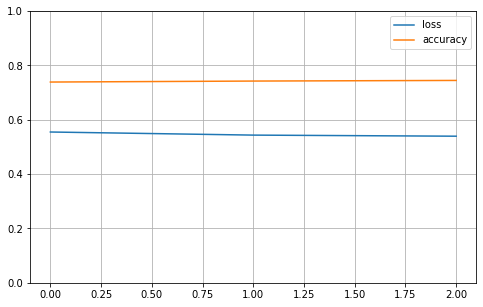

Train sizes (25698, 3997) (25698, 1)
Train set ones/size 18909 / 25698
Compute valiation accuracy
2023-01-18 22:37:50.068244
Valid sizes (6484, 3997) (6484, 1)
Valid set ones/size 4902 / 6484
Range of scores: 0.12933058 to 0.97556746
Predicted zeros and ones 295 6189
Accuracy: 75.74% Precision: 76.89% Recall: 97.08% F1: 85.82%
2023-01-18 22:37:52.088512
Fold 2
Training example
[167 155 106 ...   0   0   0]
BUILD MODEL
COMPILE
FIT
2023-01-18 22:37:57.115572
Epoch 1/3
806/806 [==============================] - 6s 6ms/step - loss: 0.5529 - accuracy: 0.7413
Epoch 2/3
806/806 [==============================] - 5s 6ms/step - loss: 0.5410 - accuracy: 0.7468
Epoch 3/3
806/806 [==============================] - 5s 6ms/step - loss: 0.5382 - accuracy: 0.7478
2023-01-18 22:38:13.233680


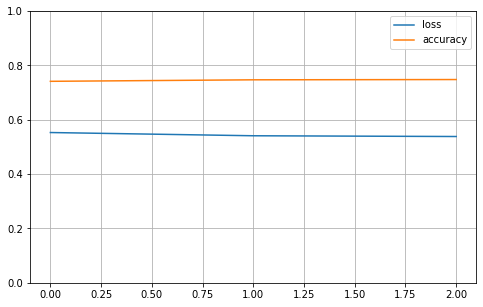

Train sizes (25781, 3997) (25781, 1)
Train set ones/size 19017 / 25781
Compute valiation accuracy
2023-01-18 22:38:14.151837
Valid sizes (6401, 3997) (6401, 1)
Valid set ones/size 4794 / 6401
Range of scores: 0.24112934 to 0.9650071
Predicted zeros and ones 324 6077
Accuracy: 74.14% Precision: 75.83% Recall: 96.12% F1: 84.78%
2023-01-18 22:38:16.204346
Fold 3
Training example
[167 155 106 ...   0   0   0]
BUILD MODEL
COMPILE
FIT
2023-01-18 22:38:21.166560
Epoch 1/3
805/805 [==============================] - 6s 7ms/step - loss: 0.5519 - accuracy: 0.7404
Epoch 2/3
805/805 [==============================] - 6s 7ms/step - loss: 0.5402 - accuracy: 0.7444
Epoch 3/3
805/805 [==============================] - 5s 6ms/step - loss: 0.5378 - accuracy: 0.7463
2023-01-18 22:38:42.502503


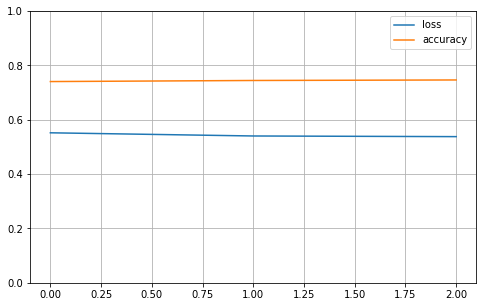

Train sizes (25752, 3997) (25752, 1)
Train set ones/size 19029 / 25752
Compute valiation accuracy
2023-01-18 22:38:42.656917
Valid sizes (6430, 3997) (6430, 1)
Valid set ones/size 4782 / 6430
Range of scores: 0.2637259 to 0.9566778
Predicted zeros and ones 321 6109
Accuracy: 74.91% Precision: 75.94% Recall: 97.01% F1: 85.19%
2023-01-18 22:38:44.689355
Fold 4
Training example
[167 155 106 ...   0   0   0]
BUILD MODEL
COMPILE
FIT
2023-01-18 22:38:49.603805
Epoch 1/3
803/803 [==============================] - 6s 6ms/step - loss: 0.5480 - accuracy: 0.7453
Epoch 2/3
803/803 [==============================] - 5s 6ms/step - loss: 0.5358 - accuracy: 0.7471
Epoch 3/3
803/803 [==============================] - 5s 6ms/step - loss: 0.5331 - accuracy: 0.7476
2023-01-18 22:39:05.490341


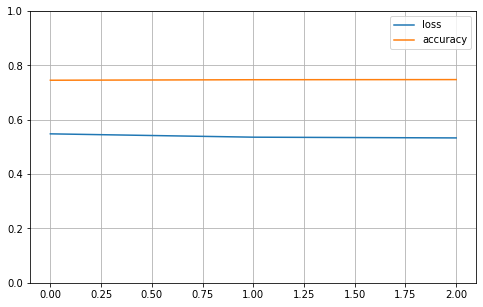

Train sizes (25695, 3997) (25695, 1)
Train set ones/size 19077 / 25695
Compute valiation accuracy
2023-01-18 22:39:05.640636
Valid sizes (6487, 3997) (6487, 1)
Valid set ones/size 4734 / 6487
Range of scores: 0.2556374 to 0.96252
Predicted zeros and ones 377 6110
Accuracy: 74.13% Precision: 75.01% Recall: 96.81% F1: 84.53%
2023-01-18 22:39:07.731855
Fold 5
Training example
[169 163 140 ...   0   0   0]
BUILD MODEL
COMPILE
FIT
2023-01-18 22:39:12.755736
Epoch 1/3
807/807 [==============================] - 6s 6ms/step - loss: 0.5475 - accuracy: 0.7447
Epoch 2/3
807/807 [==============================] - 5s 6ms/step - loss: 0.5364 - accuracy: 0.7467
Epoch 3/3
807/807 [==============================] - 5s 6ms/step - loss: 0.5341 - accuracy: 0.7489
2023-01-18 22:39:34.492823


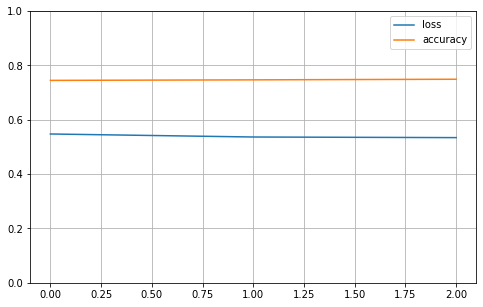

Train sizes (25802, 3997) (25802, 1)
Train set ones/size 19212 / 25802
Compute valiation accuracy
2023-01-18 22:39:34.635140
Valid sizes (6380, 3997) (6380, 1)
Valid set ones/size 4599 / 6380
Range of scores: 0.21778704 to 0.9728258
Predicted zeros and ones 325 6055
Accuracy: 73.92% Precision: 74.24% Recall: 97.74% F1: 84.38%
2023-01-18 22:39:36.661655

Cross validation 5 folds 3 epochs
 accuracy mean 74.57% +/- 0.68
 precision mean 75.58% +/- 0.90
 recall mean 96.95% +/- 0.52
 F1 mean 84.94% +/- 0.52
2023-01-18 22:39:36.662998


In [11]:
print(datetime.now())
cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
cv_accuracy, cv_precision, cv_recall, cv_f1 = cvdo.do_cross_validation()   
cvdo = None
print("Cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy)))
print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision)))
print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall)))
print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1)))
print(datetime.now())